In [41]:
from boxoffice.db.frames import get_movie_frame_full
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

df = get_movie_frame_full()

if df is None:
    print('No data')
    exit()


movies.csv exists, 1730153939.2169127, 1730153913.0134432
Reading from movies.csv


In [42]:
# main goal is to predict opening_weekend_revenue

# do a train test split based on release date. Train on movies released before 2023, test on movies released in 2023 and 2024

# drop movies with missing budgets
df = df.dropna(subset=['budget'])

# drop the opening_weekend_revenue column
df = df.drop(columns=['opening_weekend_revenue'])

# filter out movies from before 2015    
df = df[df['release_day'] >= datetime.date(2015, 1, 1)]

X_train = df[(df['release_day'] < datetime.date(2023, 1, 1))]
X_test = df[df['release_day'] >= datetime.date(2023, 1, 1)]

y_train = X_train['opening_wide_revenue']
y_test = X_test['opening_wide_revenue']

X_train = X_train.drop(columns=['opening_wide_revenue'])
X_test = X_test.drop(columns=['opening_wide_revenue'])

# reset index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [43]:
# write the titles and ids of the movies with missing budget to a csv file
missing_budget = df[df['budget'].isnull()]
missing_budget[['title', 'id']].to_csv('missing_budget.csv', index=False)

In [44]:
# create a basic MLR
from statsmodels.api import OLS

# print the columns
# print(X_train.columns)

# create dummy variables for mpaa_rating, genre, creative_type, source, production_method, and distributor
X_train_dummies = pd.get_dummies(X_train, columns=['mpaa_rating', 'genre', 'creative_type', 'source', 'production_method', 'distributor_slug'])

# print(X_train_dummies.columns)

# remove all non-numeric columns
X_train_dummies = X_train_dummies.select_dtypes(include=[np.number, np.bool])

# remove franchise id and distributor id and id
X_train_dummies = X_train_dummies.drop(columns=['franchise_id', 'distributor_id', 'id'])

# drop preview_sum and preview_to_weekend_ratio
X_train_dummies = X_train_dummies.drop(columns=['preview_sum', 'preview_to_weekend_ratio', 'first_five_days_revenue', 'first_seven_days_revenue', 'total_revenue_within_365_days', 'opening_weekend_to_total_ratio', 'fri_sat_ratio_first_five', 'sat_sun_ratio_first_five', 'sun_mon_ratio_first_five', 'mon_tue_ratio_first_five', 'tue_wed_ratio_first_five', 'wed_thu_ratio_first_five', 'thu_fri_ratio_first_five', 'fri_sat_ratio', 'sat_sun_ratio', 'sun_mon_ratio', 'mon_tue_ratio', 'tue_wed_ratio', 'wed_thu_ratio', 'thu_fri_ratio', 'total_box_office', 'largest_theater_count', 'days_over_1000_theaters', 'days_over_1000000_revenue', 'days_over_100000_revenue', 'wikipedia_cumulative_views'])

X_train_dummies = X_train_dummies.fillna(0)

# print the columns that have NaN values
print(X_train_dummies.columns[X_train_dummies.isna().any()])

# Ensure all data is numeric
X_train_dummies = X_train_dummies.astype(float)

model = OLS(y_train, X_train_dummies)
results = model.fit()

# print the summary with millions of dollars
def millions(x):
    return '{:,.2f}M'.format(x / 1000000)

print(results.summary2(float_format=millions))


Index([], dtype='object')
                                                 Results: Ordinary least squares
Model:                                   OLS                                     Adj. R-squared:                        0.752     
Dependent Variable:                      opening_wide_revenue                    AIC:                                   26966.4066
Date:                                    2024-10-28 19:24                        BIC:                                   27436.0089
No. Observations:                        738                                     Log-Likelihood:                        -13381.   
Df Model:                                101                                     F-statistic:                           23.14     
Df Residuals:                            636                                     Prob (F-statistic):                    5.19e-157 
R-squared:                               0.786                                   Scale:                    

In [45]:
# now do lasso
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

lasso = LassoCV(cv=cv, n_alphas=100, random_state=1)

lasso.fit(X_train_dummies, y_train)

print('Best alpha:', lasso.alpha_)
print('Number of non-zero coefficients:', np.sum(lasso.coef_ != 0))
# print the coefficients

# match up the coefficients with the column names
coefficients = pd.DataFrame({'feature': X_train_dummies.columns, 'coefficient': lasso.coef_})
# remove the columns with 0 coefficients
coefficients = coefficients[coefficients['coefficient'] != 0]

print(coefficients)

# print the r squared value
print('R squared:', lasso.score(X_train_dummies, y_train))


Best alpha: 1956873709953.3025
Number of non-zero coefficients: 7
                                   feature  coefficient
2                                   budget     0.207986
7               director_median_box_office    -0.265620
8                 director_mean_box_office     0.204705
9          weighted_crew_median_box_office     0.818132
11         weighted_cast_median_box_office    -0.131000
12           weighted_cast_mean_box_office     0.406628
13  wikipedia_pre_release_cumulative_views    13.914503
R squared: 0.6941871722337389


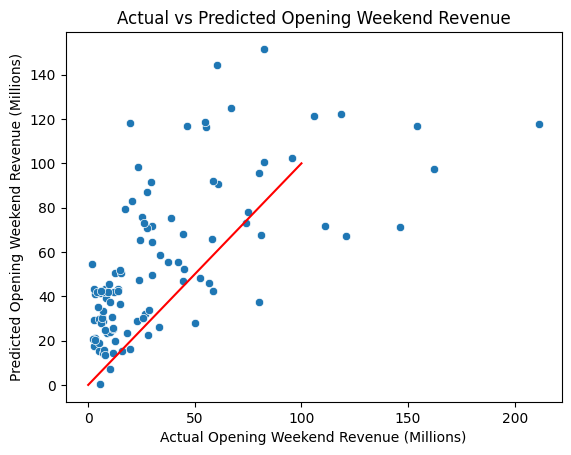

In [46]:
# now run the new model on the test data
# don't need to create dummy variables and stuff since only some variables are significant
def calculate_prediction(coefficients_df, row):
    pred_sum = 0
    for index, coef_row in coefficients_df.iterrows():
        feature = coef_row['feature']
        coefficient = coef_row['coefficient']

        pred_sum += coefficient * row[feature]

    return pred_sum

def make_predictions(coefficients_df, X):
    return X.apply(lambda x: calculate_prediction(coefficients_df, x), axis=1)

# within X_test 0 fill all NaN values
X_test = X_test.fillna(0)

y_pred = make_predictions(coefficients, X_test)

# make a results df with the names and then the values in millions
results_df = pd.DataFrame({'title': X_test['title'], 'predicted': y_pred, 'actual': y_test})
results_df['predicted'] = results_df['predicted'] / 1000000
results_df['actual'] = results_df['actual'] / 1000000

results_df.to_csv('lasso_results.csv', index=False)

# make a scatter plot of the predicted vs actual
sns.scatterplot(x='actual', y='predicted', data=results_df)
plt.xlabel('Actual Opening Weekend Revenue (Millions)')
plt.ylabel('Predicted Opening Weekend Revenue (Millions)')
plt.title('Actual vs Predicted Opening Weekend Revenue')

# make a line of y=x
plt.plot([0, 100], [0, 100], color='red')

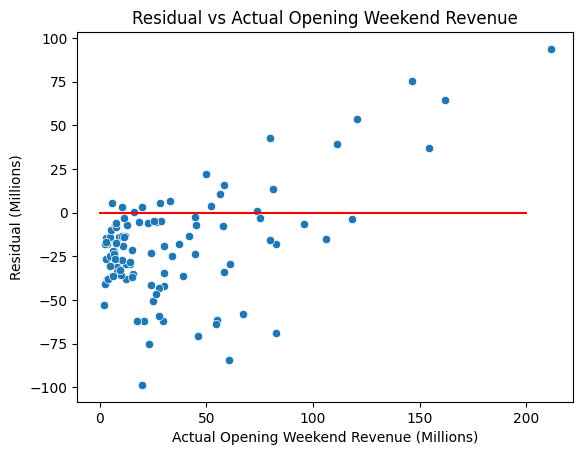

In [47]:
# plot the residuals
results_df['residual'] = results_df['actual'] - results_df['predicted']
sns.scatterplot(x='actual', y='residual', data=results_df)
plt.xlabel('Actual Opening Weekend Revenue (Millions)')
plt.ylabel('Residual (Millions)')
plt.title('Residual vs Actual Opening Weekend Revenue')

# line at y=0
plt.plot([0, 200], [0, 0], color='red')

<Axes: xlabel='wikipedia_pre_release_cumulative_views', ylabel='opening_wide_revenue'>

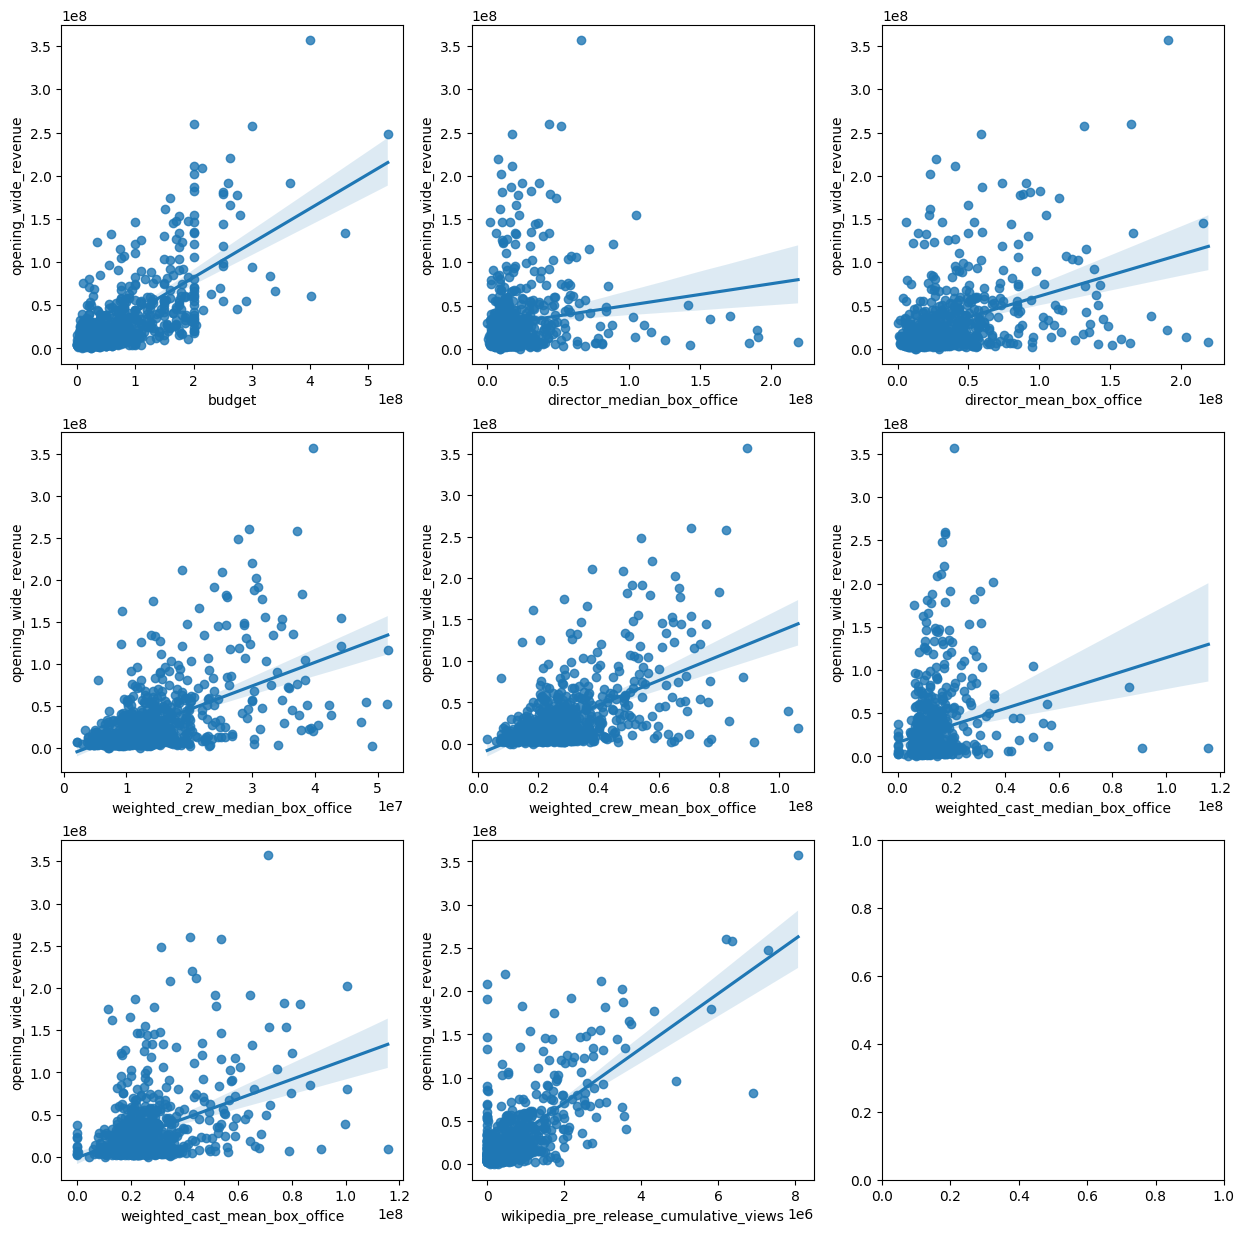

In [48]:
# the following are the features that lasso found as relevant, want to do exploratory analysis

# budget     0.272272
# 7               director_median_box_office    -0.114093
# 8                 director_mean_box_office     0.139005
# 9          weighted_crew_median_box_office     0.135436
# 10           weighted_crew_mean_box_office     0.112845
# 11         weighted_cast_median_box_office    -0.079282
# 12           weighted_cast_mean_box_office     0.145899
# 13  wikipedia_pre_release_cumulative_views     9.358108

# make a grid of scatter plots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# budget vs opening_wide_revenue
sns.regplot(x='budget', y='opening_wide_revenue', data=df, ax=axs[0, 0])

# director_median_box_office vs opening_wide_revenue
sns.regplot(x='director_median_box_office', y='opening_wide_revenue', data=df, ax=axs[0, 1])

# director_mean_box_office vs opening_wide_revenue
sns.regplot(x='director_mean_box_office', y='opening_wide_revenue', data=df, ax=axs[0, 2])

# weighted_crew_median_box_office vs opening_wide_revenue
sns.regplot(x='weighted_crew_median_box_office', y='opening_wide_revenue', data=df, ax=axs[1, 0])

# weighted_crew_mean_box_office vs opening_wide_revenue
sns.regplot(x='weighted_crew_mean_box_office', y='opening_wide_revenue', data=df, ax=axs[1, 1])

# weighted_cast_median_box_office vs opening_wide_revenue
sns.regplot(x='weighted_cast_median_box_office', y='opening_wide_revenue', data=df, ax=axs[1, 2])

# weighted_cast_mean_box_office vs opening_wide_revenue
sns.regplot(x='weighted_cast_mean_box_office', y='opening_wide_revenue', data=df, ax=axs[2, 0])

# wikipedia_pre_release_cumulative_views vs opening_wide_revenue
sns.regplot(x='wikipedia_pre_release_cumulative_views', y='opening_wide_revenue', data=df, ax=axs[2, 1])

In [50]:
# gam
from pygam import LinearGAM

gam = LinearGAM().fit(X_train_dummies, y_train)

print(gam.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    128.5459
Link Function:                     IdentityLink Log Likelihood:                                 -25518.511
Number of Samples:                          738 AIC:                                            51296.1138
                                                AICc:                                           51351.7944
                                                GCV:                                     599220700087554.0
                                                Scale:                                   414871384305696.0
                                                Pseudo R-Squared:                                   0.7769
Feature Function                  Lam

/tmp/ipykernel_239133/2122287399.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
